# Predicción de diabetes

Importamos librerías

In [199]:
!brew install libomp
%pip install seaborn

%pip install kagglehub
%pip install --upgrade category_encoders
%pip uninstall -y xgboost
%pip install xgboost
%pip install lightgbm

==> Downloading https://formulae.brew.sh/api/formula.jws.json
==> Downloading https://formulae.brew.sh/api/cask.jws.json
To reinstall 20.1.3, run:
  brew reinstall libomp
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Found existing installation: xgboost 3.0.0
Uninstalling xgboost-3.0.0:
  Successfully uninstalled xgboost-3.0.0
Note: you may need to restart the kernel to use updated packages.
  Using cached xgboost-3.0.0-py3-none-macosx_10_15_x86_64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.0-py3-none-macosx_10_15_x86_64.whl (2.2 MB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [227]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [228]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import confusion_matrix, classification_report

### Importamos el set de datos

Traemos el set de datos e iniciamos el análisis de estos.

In [229]:
# Data import
df = pd.read_csv('diabetes_prediction_dataset.csv')
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [230]:
# Descipción de datos
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [231]:
df.shape

(100000, 9)

In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


### Análisis de datos
Revisamos la distribución de los datos, empezando por el género

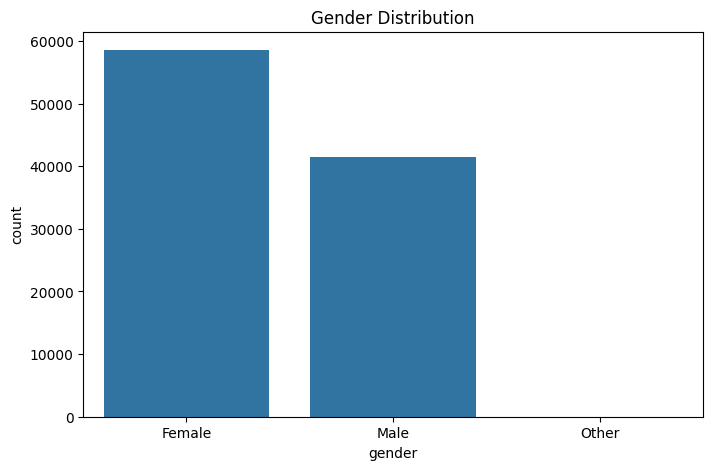

In [233]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='gender')
plt.title("Gender Distribution")
plt.show()

In [234]:
df["gender"].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [235]:
# Descartamos la categoría 'Other' del género
df = df[df['gender'] != 'Other']
# Revisamos de nuevo la distribución de género
df["gender"].value_counts()

gender
Female    58552
Male      41430
Name: count, dtype: int64

In [236]:
# Convertimos genero Hombre, Mujer, a 1, 0
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

In [237]:
# Validamos si tenemos valores vacíos
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

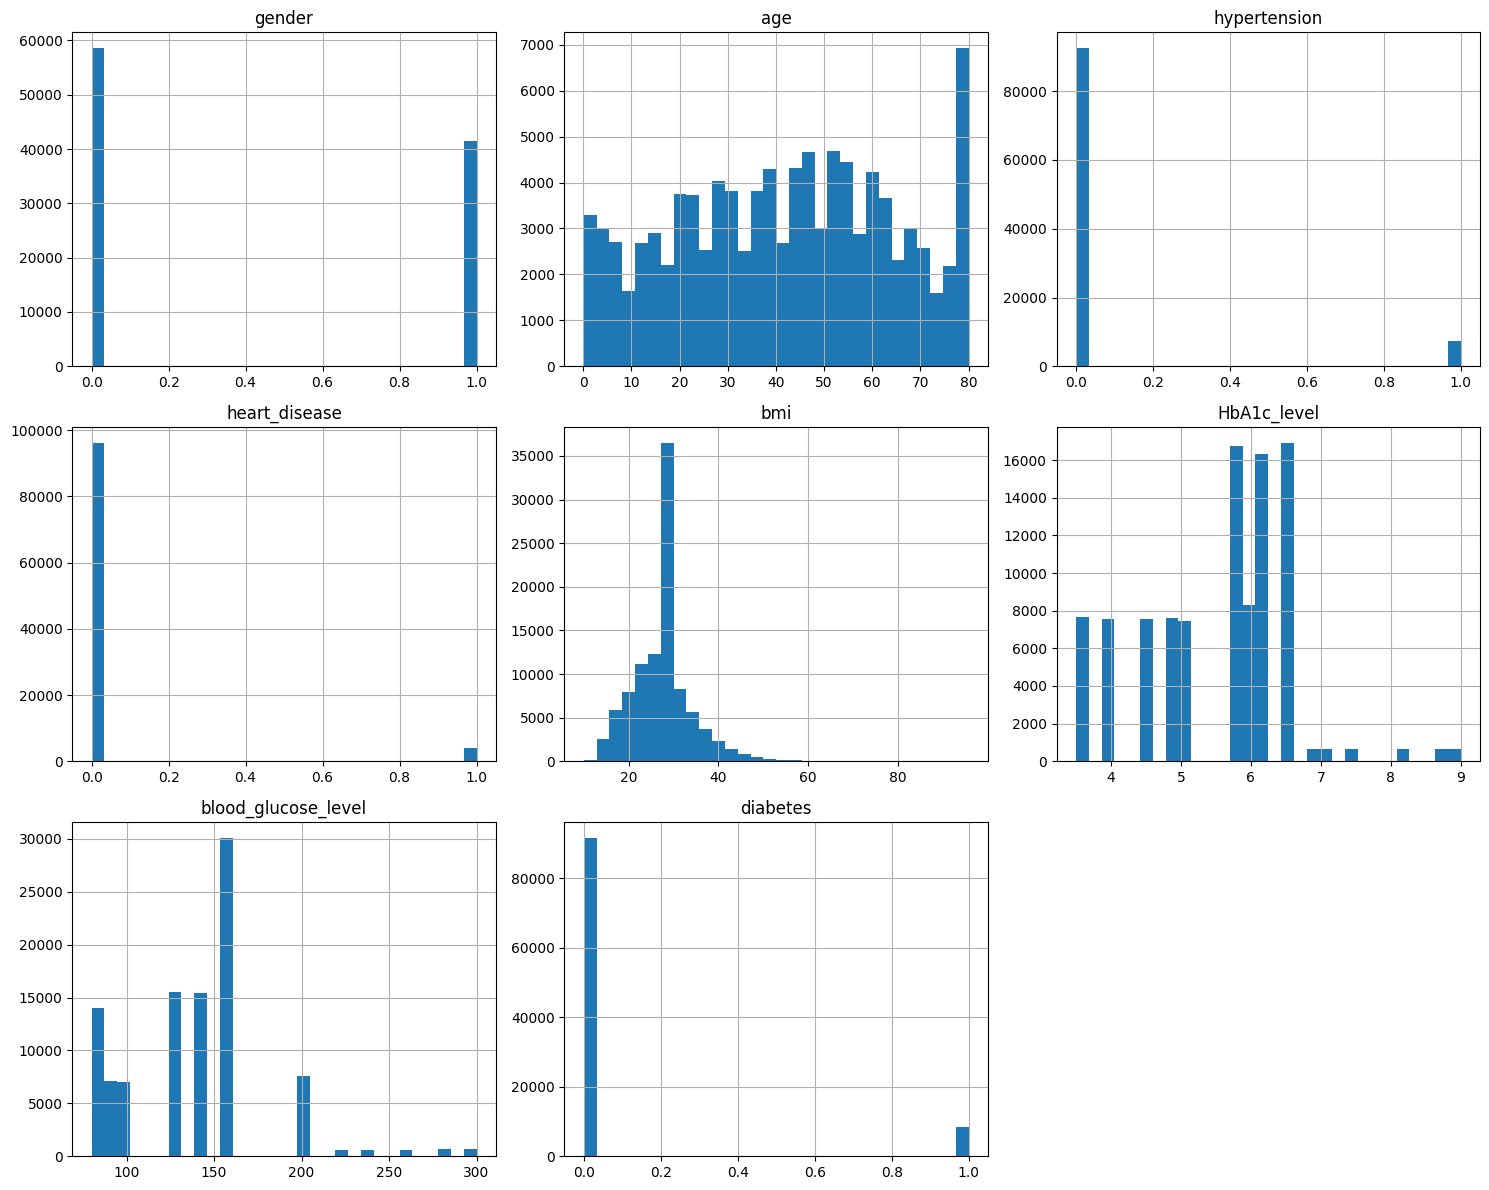

In [238]:
# Revisamos la distribución de las variables
df.hist(bins=30, figsize=(15, 12))
plt.tight_layout()
plt.show()

### Revisamos la incidencia de nuestra variable objetivo

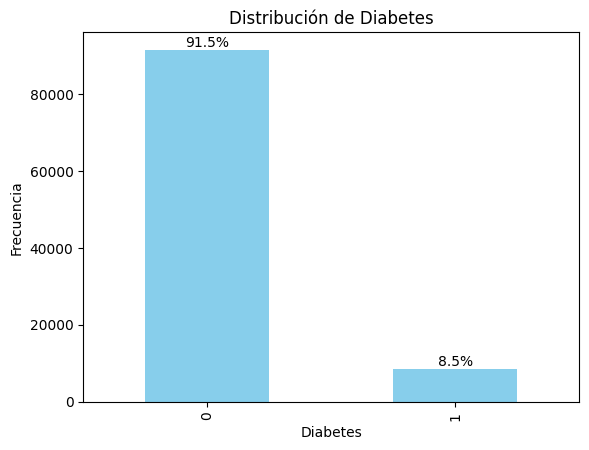

In [239]:
# Variable objetivo: Diabetes

# Calculamos la incidencia y su porcentaje respecto a la muestra
value_counts = df['diabetes'].value_counts()
percentages = (value_counts / len(df) * 100).round(2)

# Creamos un gráfico de barras para visualizar la distribución
ax = value_counts.plot(kind='bar', color='skyblue')
plt.title('Distribución de Diabetes')
plt.xlabel('Diabetes')
plt.ylabel('Frecuencia')

# Asignamos al gráfico los porcentajes
for i, count in enumerate(value_counts):
    percentage = percentages[i]
    ax.text(i, count + 1, f'{percentage}%', ha='center', va='bottom', fontsize=10)

plt.show()

In [240]:
# Revisamos los valores posibles de la variable smoking_history
unique_values = df['smoking_history'].unique()

In [241]:
# Convertimos el historial de fumador a 1, 0
# En la muestra, todos los que en algún momento han fumado son considerados fumadores
# y los que nunca han fumado son considerados no fumadores
df['smoking_history'] = df['smoking_history'].map({
    'No Info': 0,
    'never': 0,
    'former': 1,
    'current': 1,
    'not current': 1,
    'ever': 1
})

Generating Count Plots...


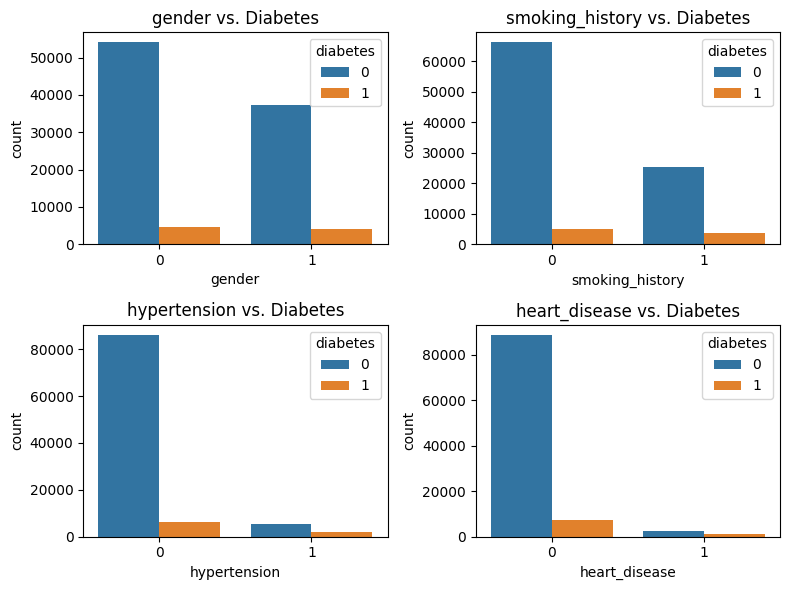

In [242]:
print("Generating Count Plots...")
categorical_cols = ['gender', 'smoking_history', 'hypertension', 'heart_disease']

# First figure with first 4 plots
fig1, axes1 = plt.subplots(2, 2, figsize=(8, 6))
axes1 = axes1.flatten()  # Flatten for easier indexing

for i in range(min(4, len(categorical_cols))):
    sns.countplot(x=categorical_cols[i], hue='diabetes', data=df, ax=axes1[i])
    axes1[i].set_title(f'{categorical_cols[i]} vs. Diabetes')

plt.tight_layout()
plt.show()

# Second figure with remaining plots
if len(categorical_cols) > 4:
    fig2, axes2 = plt.subplots(1, len(categorical_cols)-4, figsize=(8, 6))
    if len(categorical_cols) == 5:  # Handle case of just one subplot
        axes2 = [axes2]
        
    for i in range(4, len(categorical_cols)):
        sns.countplot(x=categorical_cols[i], hue='diabetes', data=df, ax=axes2[i-4])
        axes2[i-4].set_title(f'{categorical_cols[i]} vs. Diabetes')
    
    plt.tight_layout()
    plt.show()

In [243]:
# Show duplicates
df.duplicated().sum()
# Drop duplicates
df = df.drop_duplicates()
# Check again
df.duplicated().sum()

np.int64(0)

In [244]:
# Check the shape of the DataFrame
df.shape

(93718, 9)

In [245]:
df.sample(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
91442,0,73.0,0,0,1,24.15,6.5,155,0
12541,1,59.0,0,0,1,37.27,5.8,140,0
82730,1,24.0,0,0,0,30.55,5.8,200,0
82911,1,53.0,0,0,0,27.32,4.0,100,0
3510,1,48.0,0,0,1,27.32,4.5,80,0
20925,1,40.0,0,0,1,29.66,6.0,85,0
28558,1,47.0,0,0,0,38.69,6.1,130,0
78200,0,50.0,1,0,0,24.00,6.6,126,0
7819,1,50.0,0,0,0,27.32,5.7,80,0
85923,0,28.0,0,0,1,24.97,4.5,158,0


In [249]:
numeric_features = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
binary_features = ['smoking_history', 'hypertension', 'heart_disease', 'gender']

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('binary', 'passthrough', binary_features)
    ]
)

# Create the full pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Split the data
X = df.drop('diabetes', axis=1)
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the data
pipeline.fit(X_train, y_train)

# Get feature names after transformation
feature_names = numeric_features + binary_features

print("Feature names after transformation:")
print(feature_names) 

Feature names after transformation:
['age', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'smoking_history', 'hypertension', 'heart_disease', 'gender']



Métricas del modelo de Regresión Logística:
MAE (Error Absoluto Medio): 0.0424
R² (Coeficiente de Determinación): 0.4850

Matriz de Confusión:


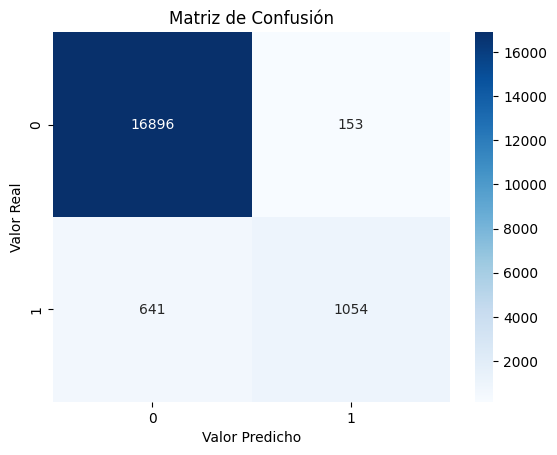


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98     17049
           1       0.87      0.62      0.73      1695

    accuracy                           0.96     18744
   macro avg       0.92      0.81      0.85     18744
weighted avg       0.96      0.96      0.95     18744



In [250]:
# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate metrics

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nMétricas del modelo de Regresión Logística:")
print(f"MAE (Error Absoluto Medio): {mae:.4f}")
print(f"R² (Coeficiente de Determinación): {r2:.4f}")

# También podemos ver la matriz de confusión para entender mejor el rendimiento

print("\nMatriz de Confusión:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

### ----------

In [ ]:
def cap_outliers(df_encoded, column):
    Q1 = df_encoded[column].quantile(0.25)
    Q3 = df_encoded[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_encoded[column] = df_encoded[column].clip(lower_bound, upper_bound)
    return df_encoded

for col in ['age', 'bmi', 'hba1c_level', 'blood_glucose_level']:
    df_encoded = cap_outliers(df_encoded, col)

In [ ]:
scaler = StandardScaler()
df_encoded[['age', 'bmi', 'hba1c_level', 'blood_glucose_level']] = scaler.fit_transform(
    df_encoded[['age', 'bmi', 'hba1c_level', 'blood_glucose_level']]
)

In [ ]:
df_encoded.dtypes

In [ ]:
print("Generating Pair Plot...")
sns.pairplot(df_encoded[['age', 'bmi', 'hba1c_level', 'blood_glucose_level', 'diabetes']], 
             hue='diabetes', diag_kind='kde')
plt.suptitle('Pair Plot of Numerical Features by Diabetes', y=1.02)
plt.show()

In [ ]:
print("Generating Box Plots...")
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
numerical_cols = ['age', 'bmi', 'hba1c_level', 'blood_glucose_level']
for i, col in enumerate(numerical_cols):
    sns.boxplot(x='diabetes', y=col, data=df_encoded, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(f'{col} vs. Diabetes')
plt.tight_layout()
plt.show()

In [ ]:
print("Diabetes Class Distribution:")
print(df_encoded['diabetes'].value_counts())

In [ ]:
df_encoded.sample(10)

In [ ]:
# Ahora vemos la correlación entre los datos

num_df = df_encoded.select_dtypes(exclude='object')
# Compute the correlation matrix
correlation_matrix = num_df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlación numérica de características')
plt.show()

In [ ]:


# Select upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.7
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.7)]

# Drop the features
df_encoded_dropped = df_encoded.drop(columns=to_drop)
plt.title('Correlación numérica de características')
plt.show()
print(f"Features dropped due to high correlation: {df_encoded_dropped}")

In [ ]:
from sklearn.model_selection import train_test_split

X = df_encoded.drop('diabetes', axis=1)
y = df_encoded['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    'Logistic Regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [None, 10, 20]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1]
        }
    },
    'Gradient Boost': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [-1, 10, 20],              
            'learning_rate': [0.01, 0.1, 0.2],
            'num_leaves': [15, 31, 63],            
            'min_child_samples': [10, 20, 50],      
            'subsample': [0.8, 1.0],                
            'colsample_bytree': [0.8, 1.0]          
    }
    }
}

### Train the models

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

results = []
hyperparameters = {}
importances_dict = {}

for name, config in models.items():
    print(f"\nTraining {name}...")

    if 'params' not in config:
        model = config['model']
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        results.append({'Model': name, 'Accuracy': accuracy})
        hyperparameters[name] = 'Default parameters'
        print(f"Used default parameters.")
        print(f"Test Accuracy: {accuracy:.3f}")

        # Try extracting importances if available
        if hasattr(model, 'feature_importances_'):
            importances_dict[name] = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances_dict[name] = np.abs(model.coef_[0])  # take abs value of weights
        else:
            importances_dict[name] = None
        continue

    # With hyperparameter tuning
    search = RandomizedSearchCV(
        config['model'],
        config['params'],
        n_iter=10,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)
    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    results.append({'Model': name, 'Accuracy': accuracy})
    results_df = pd.DataFrame(results)

    hyperparameters[name] = search.best_params_

    # Feature importances
    if hasattr(best_model, 'feature_importances_'):
        importances_dict[name] = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances_dict[name] = np.abs(best_model.coef_[0])
    else:
        importances_dict[name] = None

    print(f"Best Parameters for {name}: {search.best_params_}")
    print(f"Test Accuracy: {accuracy:.3f}")


### Visualize Model Accuracy

In [ ]:
# Create the DataFrame and sort by accuracy
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Accuracy', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=results_df, x='Model', y='Accuracy', palette='viridis')

# Annotate each bar with accuracy value
for index, row in results_df.iterrows():
    barplot.text(
        x=index,
        y=row['Accuracy'] + 0.01,  # Slightly above the bar
        s=f"{row['Accuracy']:.2f}",
        ha='center'
    )

plt.title('Model Accuracy Comparison')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Visualize Feature importance

In [ ]:
for name, importances in importances_dict.items():
    if importances is None:
        print(f"No importances available for {name}.")
        continue

    imp_series = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=imp_series.values[:10], y=imp_series.index[:10], color='teal')
    plt.title(f"Top 10 Feature Importances - {name}")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

### Implementar el modelo

Ahora vamos a tomar el model con mejor desempeño y lo vamos a usar en una pequeña "aplicación" que pide ciertos datos y retorna la probabilidad de que se padezca diabetes.

In [ ]:

# Define a function to collect input and make predictions
def predict_diabetes(model, input_dict):
    # Convert input to DataFrame
    input_df = pd.DataFrame([input_dict])
    
    # Preprocess input the same way you preprocessed training data
    # (e.g., one-hot encoding, renaming columns, filling missing values)
    # Here, assume it's already encoded to match the model
    
    # Predict probability of class 1 (diabetes)
    prob = model.predict_proba(input_df)[0][1]
    
    return prob


 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   hba1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64 

In [ ]:
# Simulated user input (replace with real inputs)
user_input = {
    'age': 75.0,
    'bmi': 58.7,
    'gender': 1,
    'hypertension': 0,
    'heart_disease': 1,
    'smoking_never': 0, 
    'smoking_no_info': 0, 
    'smoking_current': 0, 
    'smoking_not_current': 1,
    'smoking_ever': 0,
    'smoking_former': 0,
    'hypertension': 0,
    'heart_disease': 1,
    'hba1c_level': 9.8,
    'blood_glucose_level': 125 
}

# Predict
probability = predict_diabetes(best_model, user_input)
print(f"Estimated probability of diabetes: {probability:.2%}")
